In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import orekit
from pymsis import msis
import matplotlib.dates as mdates
import hrd_20250608.utilities_ds as u
from orekit.pyhelpers import setup_orekit_curdir
from os import path
import numpy as np
import pandas as pd

import hrd_20250608.rope_class_hrd as rope 
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# download_orekit_data_curdir( 'hrd_20250608/orekit-data.zip' )  # Comment this out once this file has already been downloaded for repeated runs
vm = orekit.initVM()
setup_orekit_curdir( './hrd_20250608/' )

print ( 'Java version:', vm.java_version )
print ( 'Orekit version:', orekit.VERSION )

# User inputs
forward_propagation_mins = 1  # forward propagation time (mins)
init_date = pd.to_datetime('2003-05-10 00:00:00')

latitude_values = [89.]  # degrees
local_time_values = [8.]  # hours
altitude_values = [358.]  # km
lla_array = np.vstack((latitude_values, local_time_values, altitude_values)).T.reshape((-1, 3))



Java version: 1.8.0_412
Orekit version: 13.0.1


In [24]:

# columns = [
#     'date', 'time', 'GPS', 'alt', 'lon', 'lat', 'lst', 'arglat',
#     'accelerometer_density', 'dens_mean', 'flag_dens', 'flag_dens_mean'
# ]

# file_paths = sorted(glob.glob('hrd_20250608/champ_data/*.txt'))

# df_list = []

# for file_path in file_paths:
#     df = pd.read_csv(
#         file_path,
#         delim_whitespace=True,
#         comment='#',
#         names=columns,
#         on_bad_lines='skip'  # Skip lines that cannot be parsed
#     )
#     df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
#     df.set_index('datetime', inplace=True)
#     df.drop(columns=['date', 'time', 'GPS'], inplace=True)
    
#     df_list.append(df)

# champ_all = pd.concat(df_list)

# champ_all.sort_index(inplace=True)


columns = [
    'date', 'time', 'GPS', 'alt', 'lon', 'lat', 'lst', 'arglat',
    'accelerometer_density', 'dens_mean', 'flag_dens', 'flag_dens_mean'
]

file_paths = sorted(glob.glob('hrd_20250608/grace_data/*.txt'))

df_list = []

for file_path in file_paths:
    df = pd.read_csv(
        file_path,
        delim_whitespace=True,
        comment='#',
        names=columns
    )
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.set_index('datetime', inplace=True)
    df.drop(columns=['date', 'time', 'GPS'], inplace=True)
    
    df_list.append(df)

grace_all = pd.concat(df_list)

grace_all.sort_index(inplace=True)

# columns = [
#     'date', 'time', 'GPS', 'alt', 'lon', 'lat', 'lst', 'arglat',
#     'accelerometer_density'
# ]

# file_paths = sorted(glob.glob('hrd_20250608/swarm_data/SA_*.txt'))

# df_list = []

# for file_path in file_paths:
#     df = pd.read_csv(
#         file_path,
#         delim_whitespace=True,
#         comment='#',
#         names=columns
#     )
#     df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
#     df.set_index('datetime', inplace=True)
#     df.drop(columns=['date', 'time', 'GPS'], inplace=True)
    
#     df_list.append(df)

# swarma_all = pd.concat(df_list)

# swarma_all.sort_index(inplace=True)

# file_paths = sorted(glob.glob('hrd_20250608/swarm_data/SC_*.txt'))

# df_list = []

# for file_path in file_paths:
#     df = pd.read_csv(
#         file_path,
#         delim_whitespace=True,
#         comment='#',
#         names=columns
#     )
#     df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
#     df.set_index('datetime', inplace=True)
#     df.drop(columns=['date', 'time', 'GPS'], inplace=True)
    
#     df_list.append(df)

# swarmc_all = pd.concat(df_list)

# swarmc_all.sort_index(inplace=True)

Maximum available time T = 86340s
(24,) (24,) (24,)
2003-10-28 00:00:00 2003-10-28 23:00:00
date_series, interval_interpolated_drivers[5, :]
(1440,) (1440,)
(7, 1440) (1440,) (17, 9)


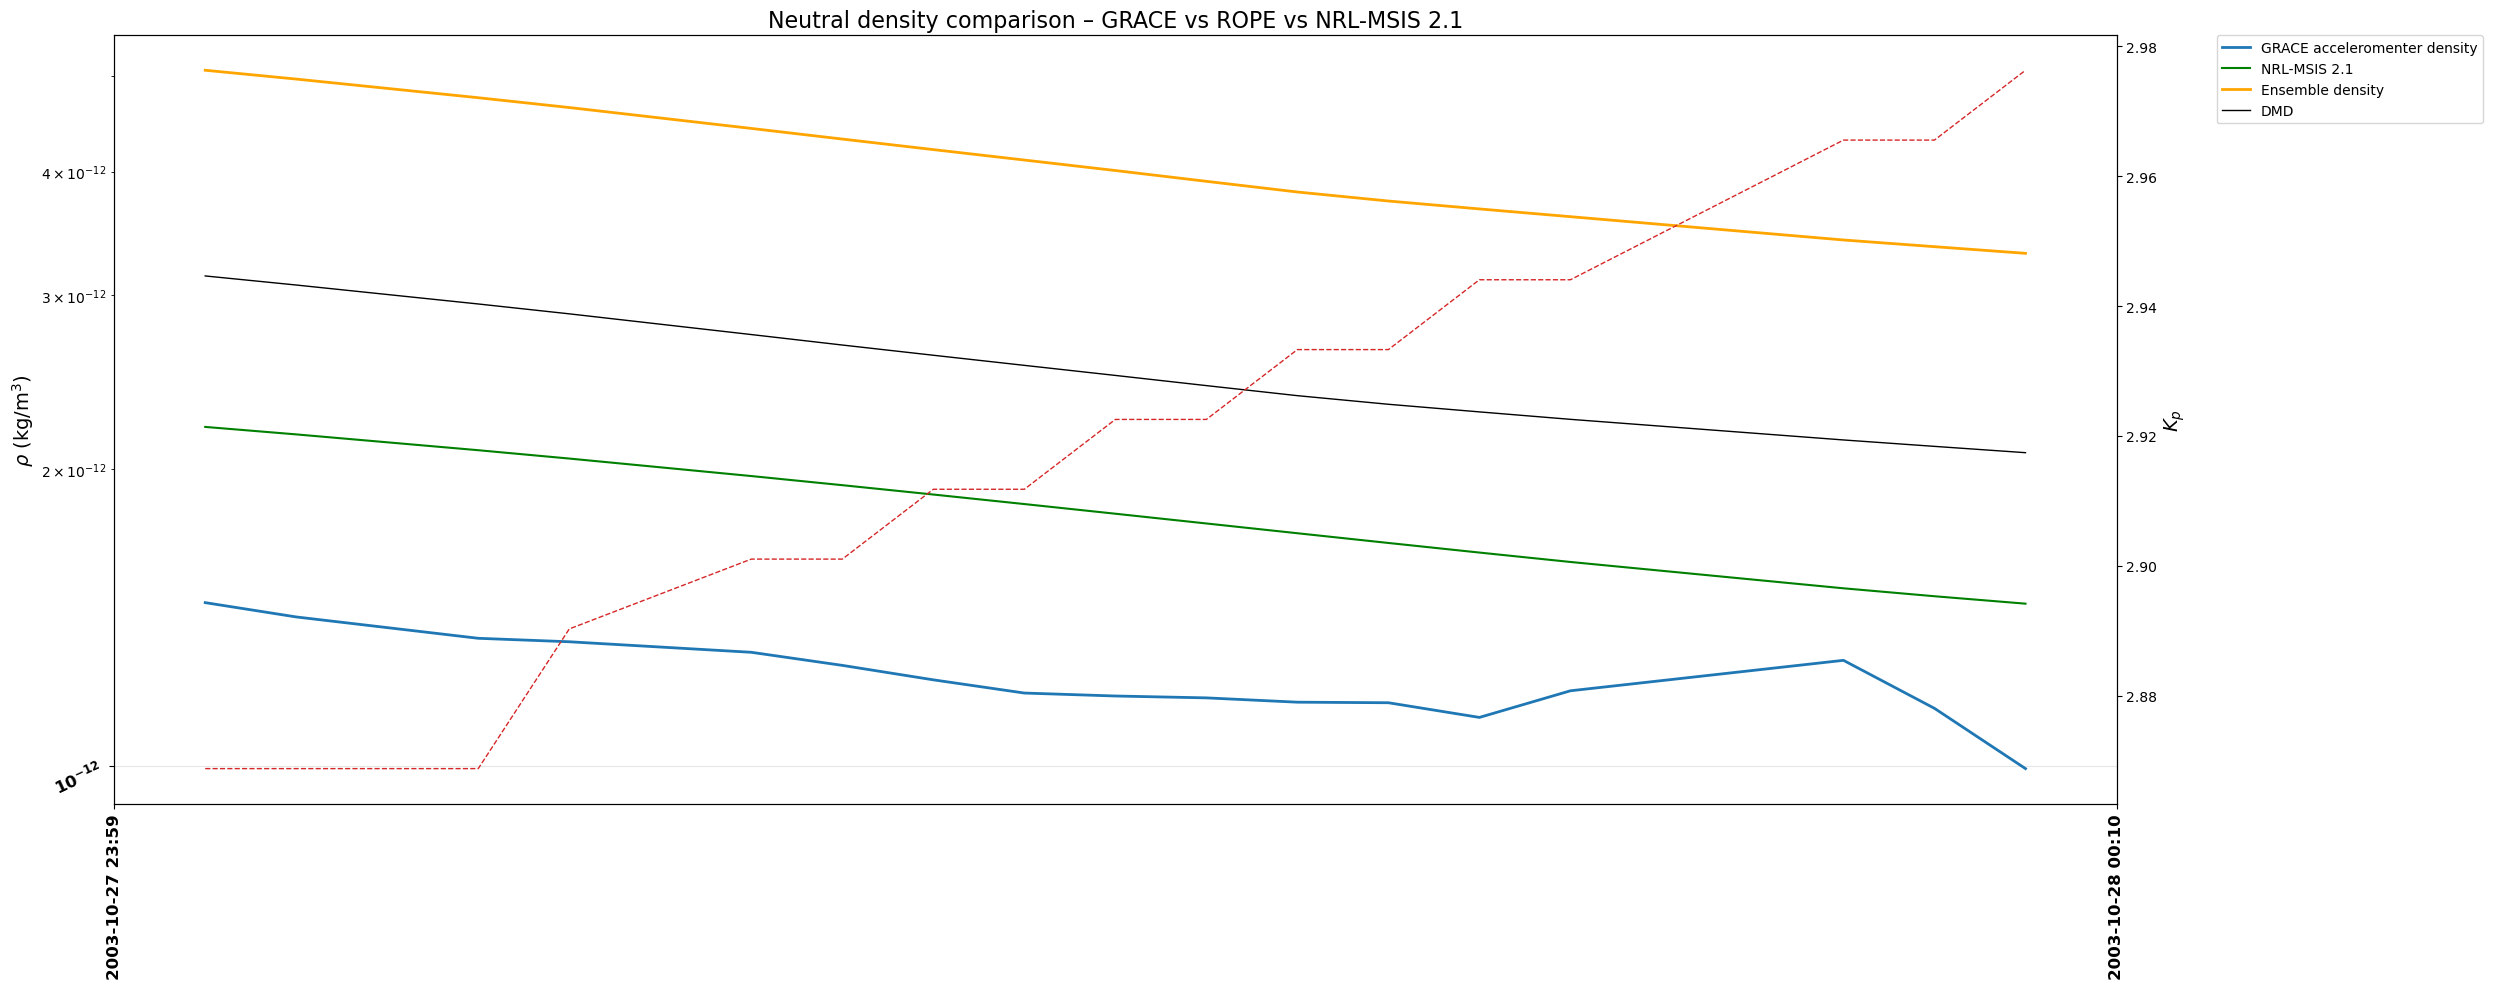

In [25]:
msis_version = 2.1
omega = 45

def plot_densities(outputs_df, satellite_name = 'GRACE-FO', plot_name = '2023a'):
    fig, ax = plt.subplots(1, 1, figsize=(25, 10), sharex=False)

    # Subplot 1 — Density comparison
    ax.semilogy(outputs_df.datetime, outputs_df.accelerometer_density, label=f"{satellite_name} acceleromenter density", color='tab:blue', linewidth=2)
    ax.semilogy(outputs_df.datetime, outputs_df.msis, label="NRL-MSIS 2.1", color='green', linewidth=1.5)
    ax.semilogy(outputs_df.datetime, outputs_df.ensemble_density, label="Ensemble density", color='orange', linewidth=2)
    # ax.plot(outputs_df.datetime, outputs_df.debiased_ensemble_density, label="Debiased ensemble density", color='red', linewidth=1.)
    # ax.fill_between(outputs_df.datetime, outputs_df.debiased_ensemble_density - outputs_df.density_std, outputs_df.debiased_ensemble_density + outputs_df.density_std,
                    #    color='red', alpha=0.2, label="Ensemble confidence interval")
    ax.semilogy(outputs_df.datetime, outputs_df.dmd, label="DMD", color='black', linewidth=1.0)


    # Labels and legend
    ax.set_ylabel(r"$\rho$ (kg/m$^3$)", fontsize=14)
    ax.set_title(f"Neutral density comparison – {satellite_name} vs ROPE vs NRL-MSIS 2.1", fontsize=16)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    

    ax12 = ax.twinx()
    ax12.plot(outputs_df.datetime, outputs_df.kp_prop, label="$K_p$", color='tab:red', linestyle='--', linewidth=1)
    ax12.set_ylabel(r"$K_p$", fontsize=14)

    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=90))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_rotation(25)
        label.set_fontweight('bold')
        label.set_fontsize(12)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.grid(True, alpha=0.3)

    plt.xticks(rotation=25)
    # ax.set_ylim(0.15e-12, 5.2e-11)
    plt.tight_layout()
    # plt.savefig(f'./imgs/{satellite_name.lower()}_vs_rope_ensemble_{plot_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def build_output_data(start_date, end_date, interpolator, msis_version, dataset):
    
    subset = dataset.loc[start_date:end_date]
    
    timestamps = subset.index.values
    latitude_values = subset.lat.values # degrees
    local_time_values = subset.lst.values # hours
    longitude_values = subset.lon.values
    altitude_values = subset.alt.values/1000. # km
    lla_array = np.vstack((latitude_values, local_time_values, altitude_values)).T.reshape((-1, 3))

    all_models, dmd_density, ensemble_density, density_std = interpolator.interpolate(timestamps, lla_array)

    result = msis.calculate(
        timestamps,
        longitude_values,
        latitude_values,
        altitude_values, 
        geomagnetic_activity=-1,
        version = msis_version
    )

    msis_rho = result[:, 0]
    accelerometer_density = subset["accelerometer_density"].values

    t1 = interpolator.data.interval_hourly_drivers[1, :]
    t2 = interpolator.data.interval_hourly_drivers[2, :]
    t3 = interpolator.data.interval_hourly_drivers[3, :]
    t4 = interpolator.data.interval_hourly_drivers[4, :]
    kp = interpolator.data.interval_hourly_drivers[6, :]
    f10 = interpolator.data.interval_hourly_drivers[5, :]
    hourly_time_series = interpolator.data.hourly_date_series

    print(hourly_time_series.shape, kp.shape, f10.shape)
    print(hourly_time_series.min(), hourly_time_series.max())

    hourly_drivers_df = pd.DataFrame({
    'datetime': pd.to_datetime(hourly_time_series),
    'f10': f10,
    'kp': kp, 't1': t1, 't2': t2, 't3': t3, 't4': t4})
    hourly_drivers_df['datetime'] = pd.to_datetime(hourly_drivers_df['datetime'])

    outputs_df = pd.merge(
        pd.DataFrame(timestamps, columns=['datetime']),
        hourly_drivers_df,
        on='datetime',
        how='left'
    )
    print('date_series, interval_interpolated_drivers[5, :]')
    print(interpolator.data.date_series.shape, interpolator.data.interval_interpolated_drivers[5, :].shape)
    interpolated_outputs = pd.DataFrame({'datetime': interpolator.data.date_series, 
        'f10_prop': interpolator.data.interval_interpolated_drivers[5, :], 
        'kp_prop': interpolator.data.interval_interpolated_drivers[6, :]})
    
    outputs_df = pd.merge(
        outputs_df,
        interpolated_outputs,
        on='datetime',
        how='left'
    )

    print(interpolator.data.interval_interpolated_drivers.shape, interpolator.data.date_series.shape, outputs_df.shape)
    outputs_df.sort_values('datetime', inplace=True)
    outputs_df.ffill(inplace=True)
    outputs_df.reset_index(drop=True, inplace=True)
    outputs_df['lst'] = local_time_values
    outputs_df['lat'] = latitude_values
    outputs_df['ensemble_density'] = ensemble_density
    outputs_df['density_std'] = density_std
    outputs_df['accelerometer_density'] = accelerometer_density
    outputs_df['msis'] = msis_rho
    outputs_df['dmd'] = dmd_density
    

    return timestamps, accelerometer_density, ensemble_density, dmd_density, \
        density_std, msis_rho, outputs_df, latitude_values, local_time_values


# def run_demo(start_date, end_date, rope_density, msis_version, dataset, bias_propagation):

#     timestamps, accelerometer_density, ensemble_density, dmd_density, \
#         density_std, msis_rho, outputs_df, latitudes, lst_values = \
#             build_output_data(start_date, end_date, rope_density, msis_version, dataset)
    
#     return outputs_df

def run_model(start_date, end_date, rope_density, msis_version, dataset):

    timestamps, accelerometer_density, ensemble_density, dmd_density, \
        density_std, msis_rho, outputs_df, latitudes, lst_values = \
            build_output_data(start_date, end_date, rope_density, msis_version, dataset)
    
    return outputs_df

# Latest Ridge parameters are [1., 1000, 10000, 100000]
for alpha_ridge in [1]:
    selected_bf_dict = {
            'poly': 1000,
            # 'poly17': 500,
            # 'poly12': 1000,
            # 'poly13': 10,
            # 'poly135': 500, 
            # 'poly1357': 10, 
            # 'poly_sincos4': 100, 
            # 'poly_sincos7': alpha_ridge,
            # 'poly_exp1': alpha_ridge,
            # 'poly_exp2': alpha_ridge,
            # 'poly_exp12': alpha_ridge,
            # 'poly_exp22': alpha_ridge
        }
    # for basis in all_bf_dict.keys():
    #     for alpha_ridge in [1, 5, 10, 100, 1000, 10000, 100000]:

    # selected_bf_dict = {
    #         basis: alpha_ridge
    #     }

    lst_bias = 0. #-2.0 is good
    alt_bias = 0.#40.
    delta_rho_ic = 6

    lt_low = 0
    lt_high = 23.66666667

    lat_low = -87.5
    lat_high = 87.5

    alt_low = 100
    alt_high = 980

    # #Check if start and end dates are compatible with forward_propagation


    # # for bp in np.arange(1, 20):
    # bias_propagation = 1


    start_date = "2003-10-28 00:00:00"
    end_date = "2003-10-28 00:10:00"
    forward_propagation_mins = 1
    satellite_name = 'GRACE'
    plot_name = '2003'
    dataset = grace_all


    sindy = rope.rope_propagator(selected_bf_dict = selected_bf_dict, delta_rho_ic = delta_rho_ic)
    sindy.propagate_models_mins(init_date = start_date, forward_propagation = forward_propagation_mins)
    rope_density = rope.rope_data_interpolator( data = sindy)

    outputs_df = run_model(start_date, end_date, rope_density, msis_version, dataset)
    plot_densities(outputs_df, satellite_name = satellite_name, plot_name = plot_name)


In [26]:
# Save outputs_df to an Excel sheet
excel_file_path = 'output_data.xlsx'
outputs_df.to_excel(excel_file_path, index=False)

In [27]:
outputs_df

,datetime,f10,kp,t1,t2,t3,t4,f10_prop,kp_prop,lst,lat,ensemble_density,density_std,accelerometer_density,msis,dmd
0,2003-10-28 00:00:00,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.258977,2.868816,16.099,43.873855,5.066292e-12,9.653737e-13,1.463398e-12,2.204828e-12,3.135544e-12
1,2003-10-28 00:00:30,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.258977,2.868816,16.104,45.783317,4.963070e-12,9.466160e-13,1.415334e-12,2.166696e-12,3.069838e-12
2,2003-10-28 00:01:30,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.258977,2.868816,16.113,49.600603,4.751795e-12,9.073506e-13,1.346600e-12,2.088184e-12,2.937094e-12
3,2003-10-28 00:02:00,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.282083,2.890309,16.119,51.508424,4.644363e-12,8.870489e-13,1.335730e-12,2.047980e-12,2.870265e-12
4,2003-10-28 00:03:00,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.293635,2.901056,16.131,55.322430,4.423361e-12,8.442265e-13,1.303341e-12,1.966060e-12,2.734908e-12
5,2003-10-28 00:03:30,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.293635,2.901056,16.138,57.228620,4.314983e-12,8.230568e-13,1.264157e-12,1.924652e-12,2.668870e-12
6,2003-10-28 00:04:00,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.305188,2.911803,16.146,59.134272,4.210250e-12,8.021323e-13,1.222230e-12,1.883132e-12,2.605986e-12
7,2003-10-28 00:04:30,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.305188,2.911803,16.155,61.039389,4.108905e-12,7.818054e-13,1.185145e-12,1.841736e-12,2.545294e-12
8,2003-10-28 00:05:00,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.316741,2.922550,16.165,62.943970,4.009681e-12,7.617380e-13,1.176989e-12,1.800667e-12,2.486205e-12
9,2003-10-28 00:05:30,274.4,3.0,1.0,0.0,0.448906,-0.893579,274.316741,2.922550,16.176,64.848009,3.909948e-12,7.410497e-13,1.171879e-12,1.760183e-12,2.427848e-12
